In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [2]:
test = pd.read_csv("test.csv", encoding = 'utf-8', delimiter = ',')
train = pd.read_csv("train.csv", encoding = 'utf-8', delimiter = ',')
g_s = pd.read_csv("gender_submission.csv", encoding = 'utf-8', delimiter = ',')

In [3]:
merged = test.merge(g_s, how = 'right', on = 'PassengerId')
df = pd.concat([train, merged], axis = 0, join = 'outer')

#Data preprocessing

In [4]:
# Loading a random sample from the dataset

df.sample(frac = 0.6, random_state = 1).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S
115,116,0,3,"Pekoniemi, Mr. Edvard",male,21.0,0,0,STON/O 2. 3101294,7.9250,NaN,S
255,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C
212,1104,0,2,"Deacon, Mr. Percy William",male,17.0,0,0,S.O.C. 14879,73.5000,NaN,S
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C


In [5]:
# How many rows and columns are in the table?

print('Number of sample rows:', len(df))
print('Number of sample columns:', len(df.columns))

Number of sample rows: 1309
Number of sample columns: 12


In [6]:
# What are the column names?
# What are the data types of the different columns?
# How many unique values are in each of them?
# How many missed?

def nulls(s):
    return s.size - s.count()

summary = df.agg(['nunique', nulls, 'dtypes'])
summary


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
nunique,1309,2,3,1307,2,98,7,8,929,281,186,3
nulls,0,0,0,0,0,263,0,0,0,1,1014,2
dtypes,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,object


In [7]:
# How many duplicates?

print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 0


In [8]:
# Deleting/filling NaN values, deleting insignificant data

df.drop(labels=['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
df['Age'].fillna(df['Age'].mean(), inplace = True)
df.dropna(inplace = True)

In [9]:
summary1 = df.agg(['nunique', nulls, 'dtypes'])
summary1

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
nunique,1306,2,3,2,98,7,8,280,3
nulls,0,0,0,0,0,0,0,0,0
dtypes,int64,int64,int64,object,float64,int64,int64,float64,object


In [10]:
df_m = copy.deepcopy(df)

---

#Data analysis

Survived passengers: 492


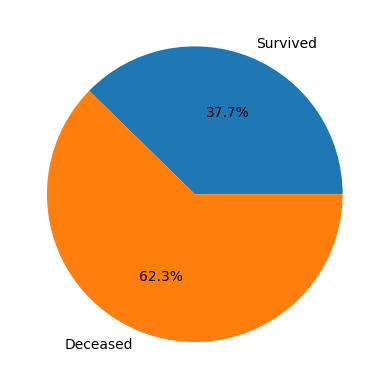

In [11]:
# Number of survivors

num_survived = df.PassengerId[df.Survived == 1].count()
num_died = len(df) - num_survived

labels = 'Survived', 'Deceased'
surv = [num_survived, num_died]

fig, ax = plt.subplots()
ax.pie(surv, labels = labels, autopct='%1.1f%%')

print('Survived passengers:', num_survived)

492 passengers (37.7% of total) survived.

Passenger class dependence of survival


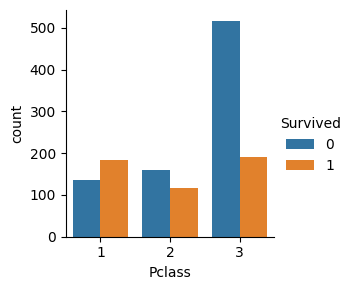

In [12]:
# Passenger class dependence of survival

print('Passenger class dependence of survival')
sns.catplot(data = df, hue = 'Survived', x = 'Pclass', kind = 'count', height = 3)

Deceased-to-survived ratio exceeds 2 among the 3rd class passengers.

Gender dependence of survival


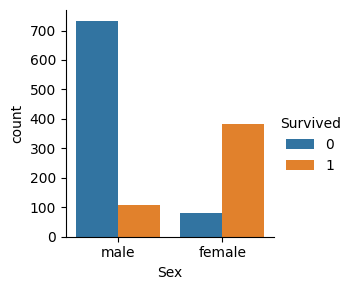

In [13]:
# Gender dependence of survival

print('Gender dependence of survival')
sns.catplot(data = df, hue = 'Survived', x = 'Sex', kind = 'count', height = 3)

The bar chart above depicts that most of decedents are men.

Family size dependence of survival


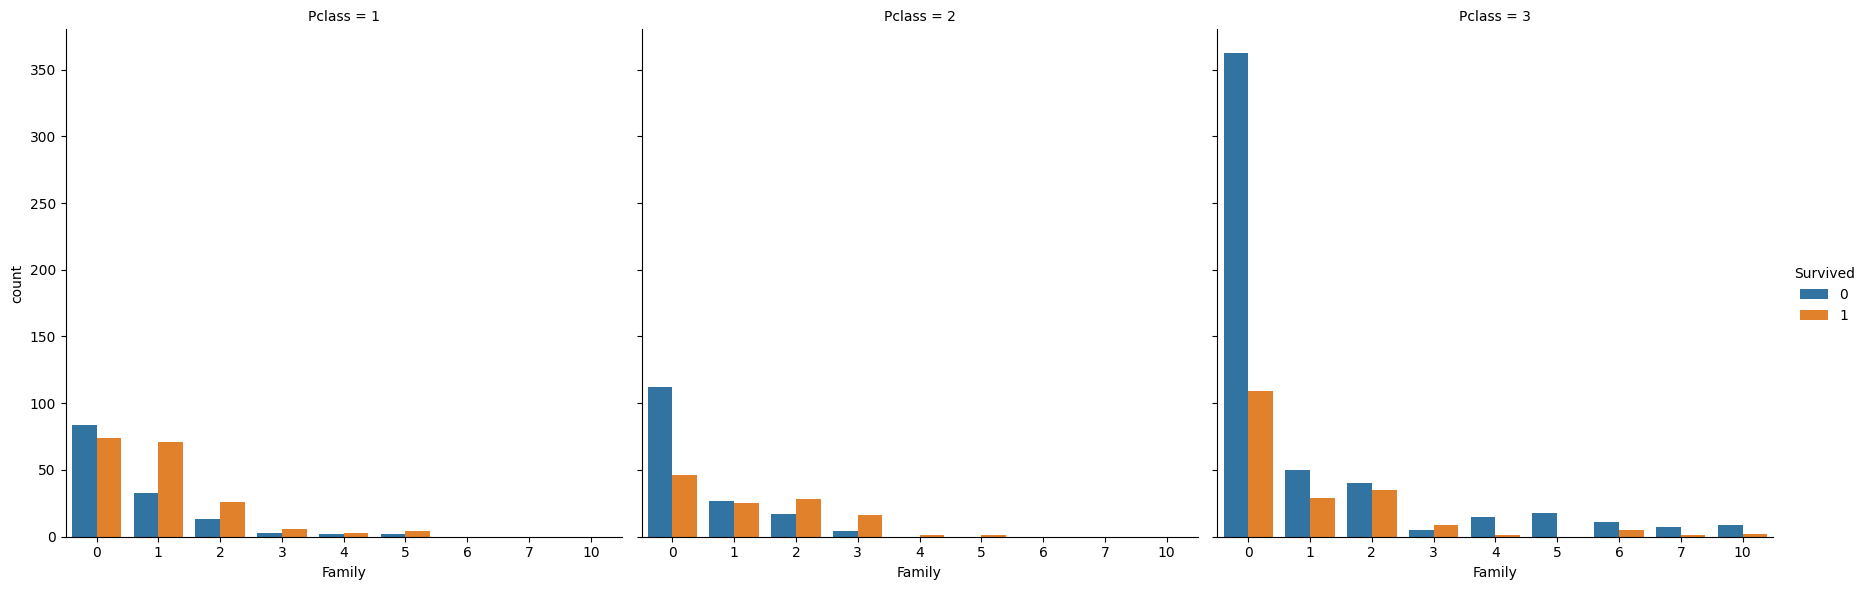

In [14]:
# Family size dependence of survival

df['Family'] = df['Parch'] + df['SibSp']

print('Family size dependence of survival')
sns.catplot(data = df, hue = 'Survived', x = 'Family', kind = 'count', col = 'Pclass', height = 6)

The bar charts show the passengers with no relatives are more likely to decease.

Family size dependence of passenger class


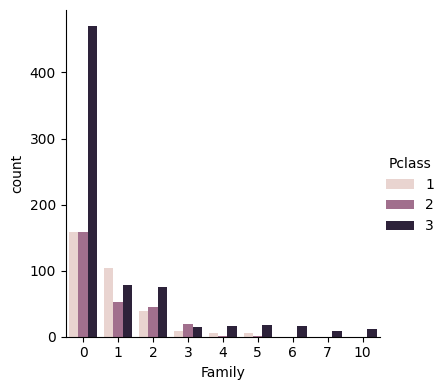

In [15]:
# Family size dependence of passenger class

print('Family size dependence of passenger class')
sns.catplot(data = df, hue = 'Pclass', x = 'Family', kind = 'count', height = 4)

The bar chart shows almost proportional distribution from single passengers to four-person families between all classes.

However, it can be noticed the larger families choose the 3rd class predominantly.

Family size dependence of ticket price


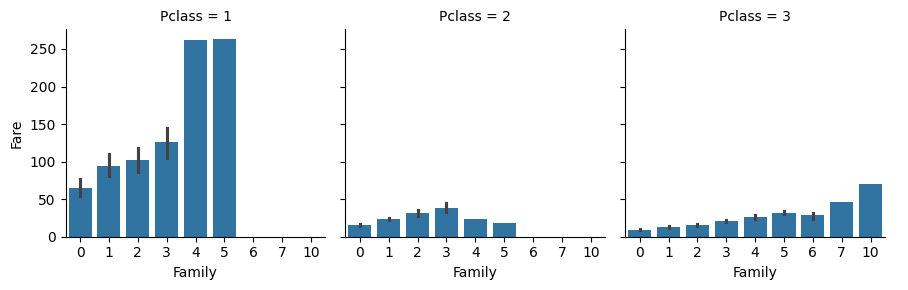

In [16]:
# Family size dependence of ticket price

print('Family size dependence of ticket price')
sns.catplot(data = df, y = 'Fare', x = 'Family', kind = 'bar', col = 'Pclass', height = 3)

In the bar chart one can see the fare changes in ascending order as the family size increases.

In [17]:
df.Fare.describe()

count    1306.000000
mean       33.223956
std        51.765986
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [18]:
# Dividing tickets into price categories

df.insert(9, 'PriceCat', ['Cheap' if fare <= 25
                              else 'Average cost' if fare > 25 and fare <= 70
                              else 'Expensive' for fare in df['Fare']])

Survival dependence of ticket price category


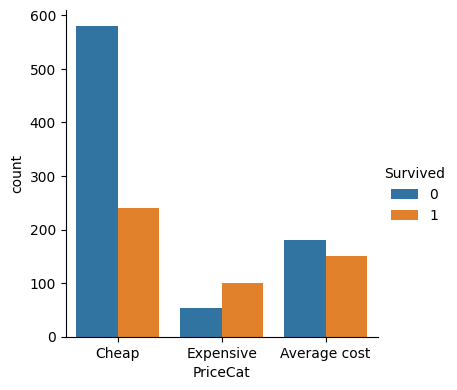

In [19]:
# Survival dependence of ticket price category

print('Survival dependence of ticket price category')
sns.catplot(data = df, hue = 'Survived', x = 'PriceCat', kind = 'count', height = 4)

The bar chart shows the 'Expensive' ticket category survived-to-deceased ratio is almost 2. Hence, the passenger who purchased ticket of that price category is more likely to survive.

Survival dependence of age (age & gender)


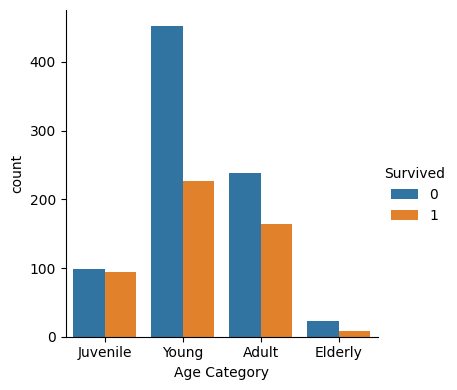

In [20]:
# Survival dependence of age (age & gender)

df['Age Category'] = pd.cut(df['Age'], bins=[0, 18, 30, 60, float('inf')], labels=['Juvenile', 'Young', 'Adult', 'Elderly'])

print('Survival dependence of age (age & gender)')
sns.catplot(data = df, hue = 'Survived', x = 'Age Category', kind = 'count', height = 4)

The most survivous age category is a "Juvenile".

---

Survival dependence of age & gender


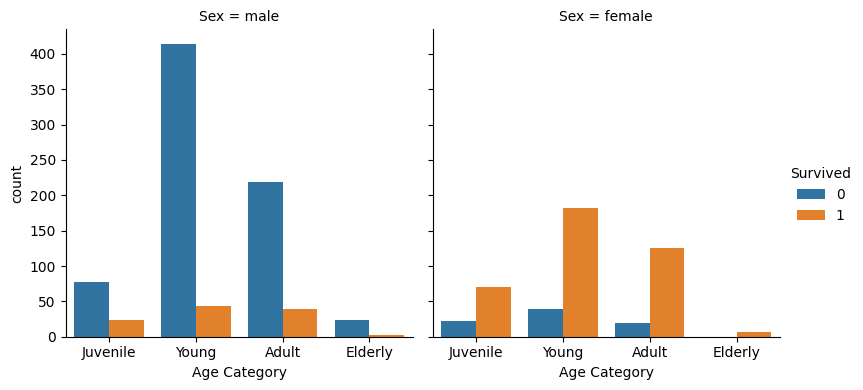

In [21]:
print('Survival dependence of age & gender')
sns.catplot(data = df, hue = 'Survived', x = 'Age Category', kind = 'count', col = 'Sex', height = 4)

Among women - which are mentioned above as the most survivous gender category - the adult ones (from 30 to 60) have more chances not to decease.

#Summary

* Passenger class dependence of survival - the higher passenger class, the more chances of survival;

* Gender dependence of survival - there are about 4-fold as many women survived than men;

* Family size dependence of survival - the vast majority of passengers travel alone or with 1 or 2 relatives, the survival ability of passengers with at least 1 relative increasing several times;

* Family size dependence of ticket price/class - the price incrises as the family size incrises, families of 1 to 4 persons are almost evenly distributed by classes. However, larger families prefer 3rd class.

* Survival dependence of ticket price category - 'Expensive' ticket category is the most 'survivous'.

* Survival dependence of age and gender - The most survivous age category is a "Juvenile". Among women the adult ones (from 30 to 60) have more chances not to decease.





---



#Model building

In [22]:
# Let us corvert categorical features to numerical

df_m['Sex'] = df_m['Sex'].map({'male': 0, 'female': 1})
df_m['Embarked'] = df_m['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [23]:
df_m.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0


In [28]:
# Splitting to train and test samples

X = df_m.drop(['Survived'], axis = 1)
y = df_m['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [29]:
# Model training

model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
# Metrics estimation

F1 = f1_score(y_test, y_pred)
accuracy  = accuracy_score(y_test, y_pred)
print("F1-score:", round(F1, 3))
print("Accuracy:", round(accuracy, 3), '\n')
print(classification_report(y_test, y_pred, digits = 3))

F1-score: 0.845
Accuracy: 0.889 

              precision    recall  f1-score   support

           0      0.885     0.945     0.914       163
           1      0.898     0.798     0.845        99

    accuracy                          0.889       262
   macro avg      0.891     0.871     0.879       262
weighted avg      0.890     0.889     0.888       262



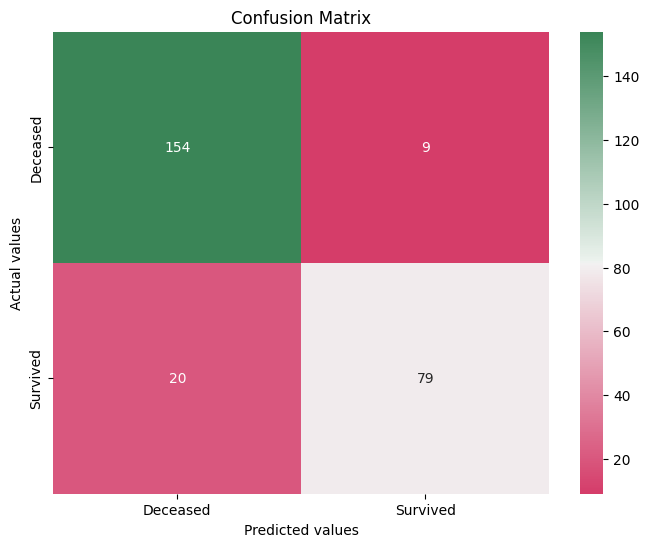

In [31]:
# Confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = sns.diverging_palette(0, 500, as_cmap=True),
            xticklabels=["Deceased", "Survived"],
            yticklabels=["Deceased", "Survived"])
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Confusion Matrix")
plt.show()

To sum up, the Titatic dataset was preprocessed, exploratory data analysis being performed, and then the Random Forest Classificator model was trained and evaluated by F1-score and accuracy metrics (0.845 and 0.889 correspondingly).